In [11]:
%run ../../scripts/functions.py
%run ../../scAAnet/api.py
%run ../../scAAnet/train.py
%run ../../scAAnet/network.py
%run ../../scAAnet/tools.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
figure_output = '../../figures/exp03/4_figures'
data_path = '../../data/only_healthy_data'
bc = pd.read_csv(f'{data_path}/batchfix_paths_healthy_samples_pathway_counts.csv', sep=',', index_col=0, header=0)
no_bc = pd.read_csv(f'{data_path}/filtered_paths_healthy_samples_pathway_counts.csv', sep=',', index_col=0, header=0)
metadata = pd.read_csv(f'{data_path}/batchfix_paths_healthy_samples_pathway_metadata.csv', sep=',', index_col=0, header=0)
metadata.rename(columns={'Global.Region': 'Global Region'}, inplace=True)
no_bc = no_bc.loc[:,no_bc.columns.isin(bc)]

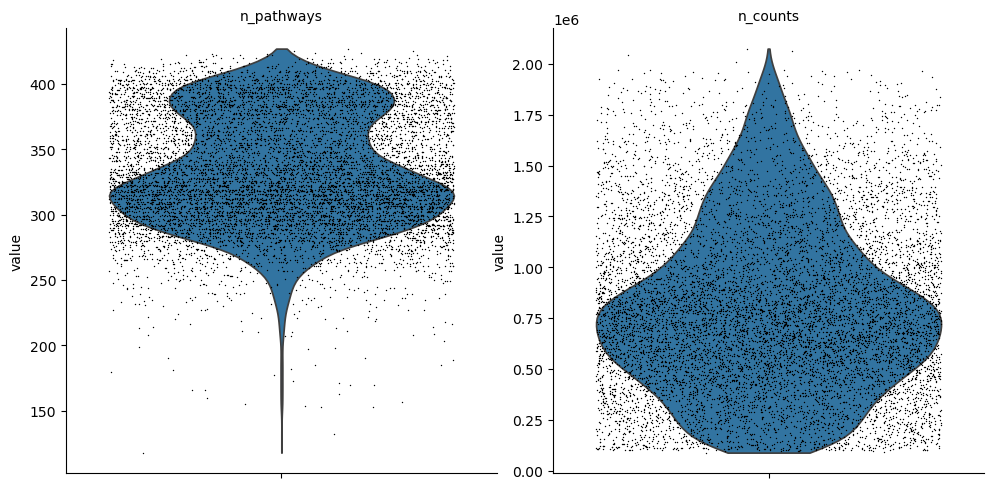

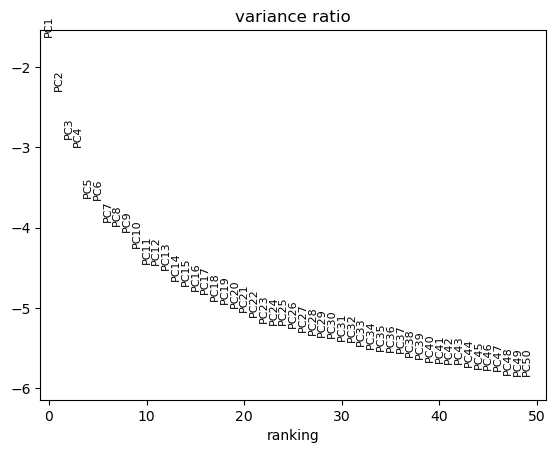

/data/lab_vm/campervans/mmeawad_test/anaconda/test4.2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


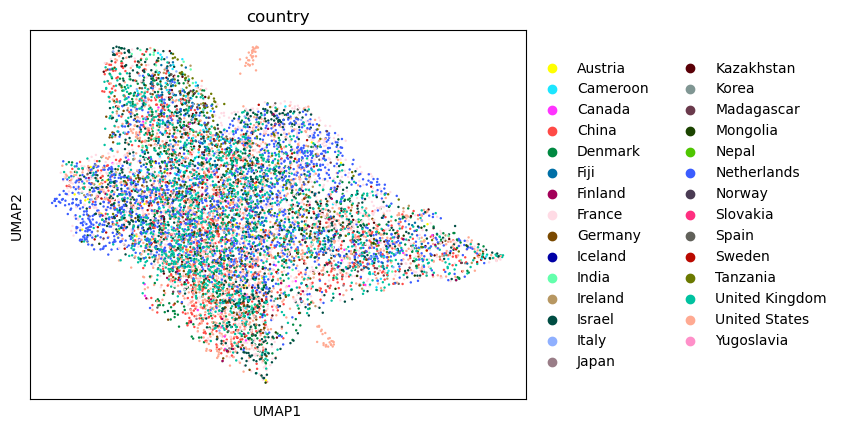

/data/lab_vm/campervans/mmeawad_test/anaconda/test4.2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


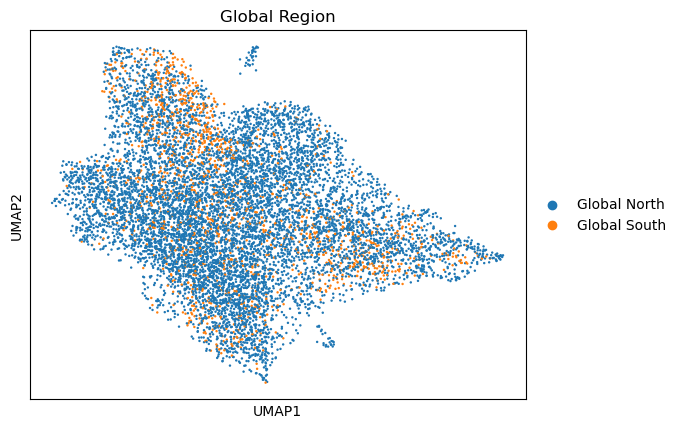

/data/lab_vm/campervans/mmeawad_test/anaconda/test4.2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


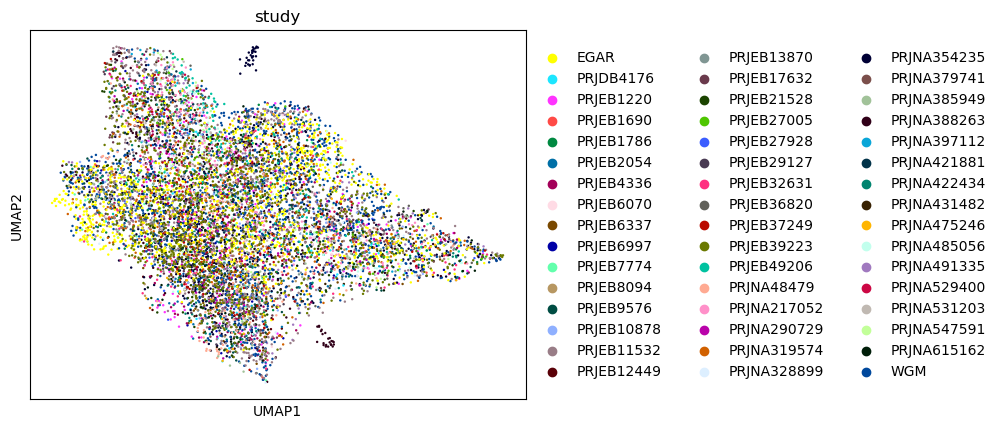

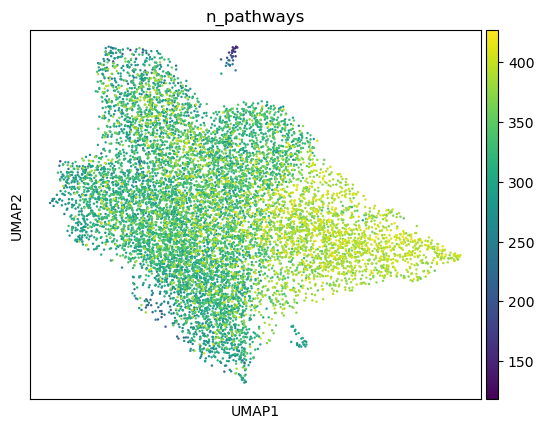

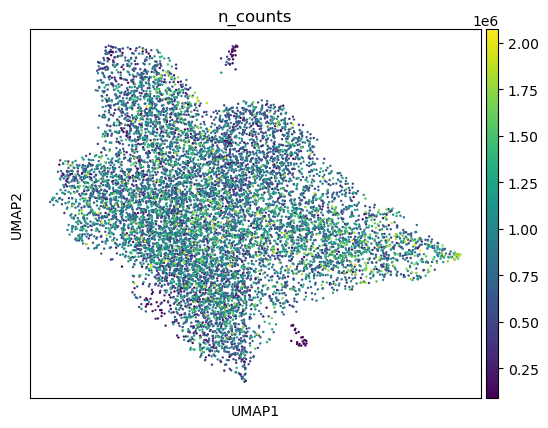

In [6]:
concat_ad = convertToAnnData(bc, metadata)

# post batch correction usage 

In [7]:
import pickle
with open('../../data/scAAnet_output/clean_100_rs.pkl', 'rb') as f:
    clean_100_states = pickle.load(f)

dist = 'nb'
K = 3

counts = concat_ad
recon = clean_100_states[(3, 53)]['recon']
usage = clean_100_states[(3, 53)]['usage']
spectra = clean_100_states[(3, 53)]['spectra']
gene_score = clean_100_states[(3, 53)]['gene_score']
gene_score.index = bc.index
usage = pd.DataFrame(usage, index=counts.obs.index, columns = np.arange(1,K+1))
usage.columns = ['type3', 'type1', 'type2']
desired_order = ['type1', 'type2', 'type3']
usage = usage[desired_order]
gene_score.columns = ['type3', 'type1', 'type2']
desired_order = ['type1', 'type2', 'type3']
gene_score = gene_score[desired_order]

spectra = pd.DataFrame(np.transpose(spectra), index=counts.var.index, columns=usage.columns)
recon = pd.DataFrame(recon, index=counts.obs.index, columns=counts.var.index)
usage = usage.apply(pd.to_numeric, errors='coerce').astype('float64')


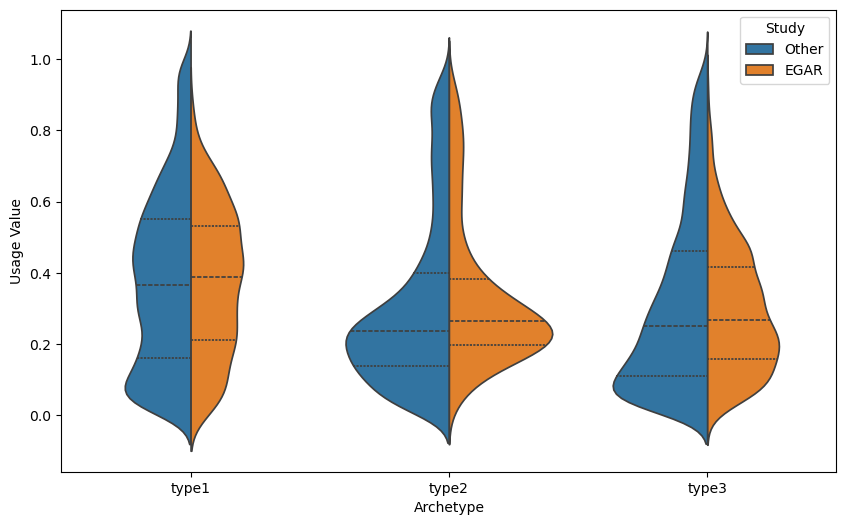

In [8]:
# Filter rows based on study column in metadata
egar_rows = metadata[metadata['study'] == 'EGAR']
other_rows = metadata[metadata['study'] != 'EGAR']  # Everything else is "Other"

# Add a new column to the usage dataframe to label the categories
usage['category'] = 'Other'  # Default category
usage.loc[egar_rows.index, 'category'] = 'EGAR'

# Filter usage to include only "EGAR" and "Other" categories
usage_filtered = usage[usage['category'].isin(['EGAR', 'Other'])]

# Melt the DataFrame for easier plotting
melted_usage = usage_filtered.melt(
    id_vars='category', 
    value_vars=['type1', 'type2', 'type3'], 
    var_name='Archetype', 
    value_name='Value'
)

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=melted_usage, x='Archetype', y='Value', hue='category', split=True, inner='quartile')
plt.xlabel('Archetype')
plt.ylabel('Usage Value')
plt.legend(title='Study')
plt.savefig(f"{figure_output}/S3B_post_bc_usage_violin.pdf")
plt.show()


# pre batch correction usage

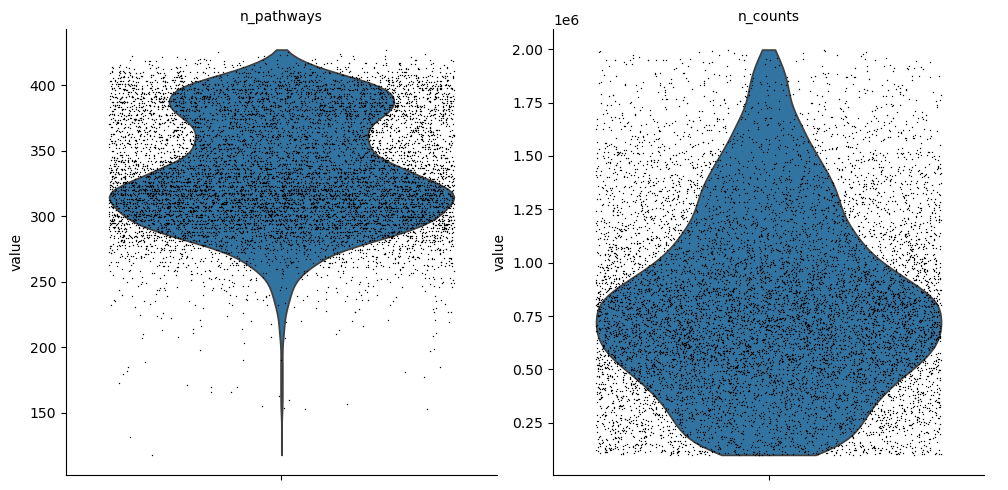

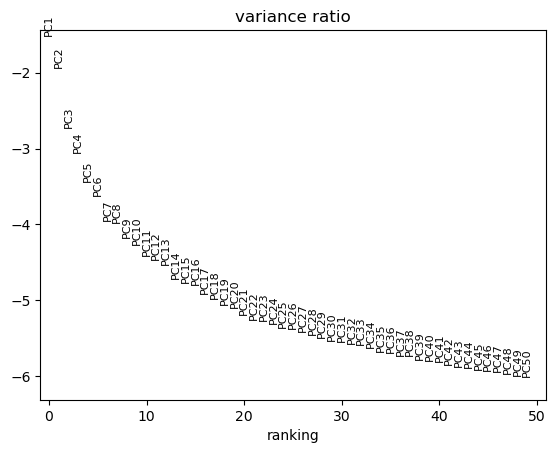

/data/lab_vm/campervans/mmeawad_test/anaconda/test4.2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


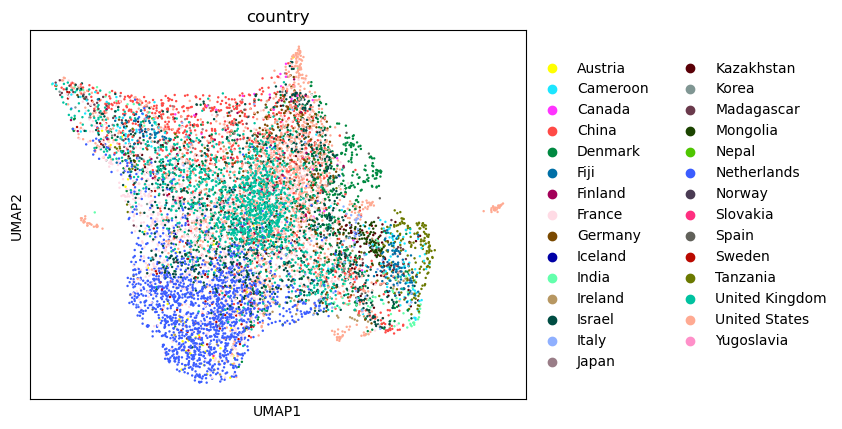

/data/lab_vm/campervans/mmeawad_test/anaconda/test4.2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


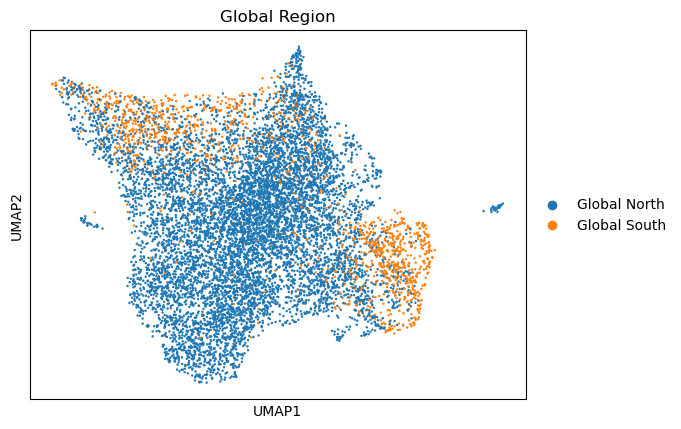

/data/lab_vm/campervans/mmeawad_test/anaconda/test4.2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


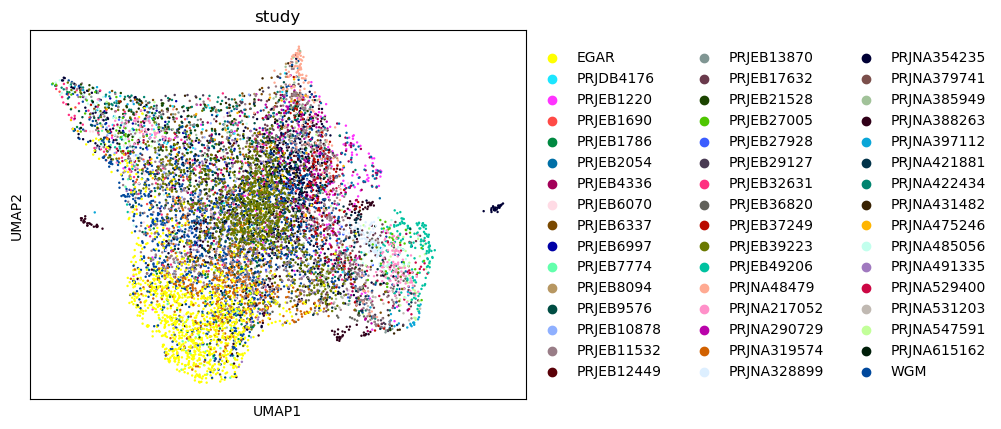

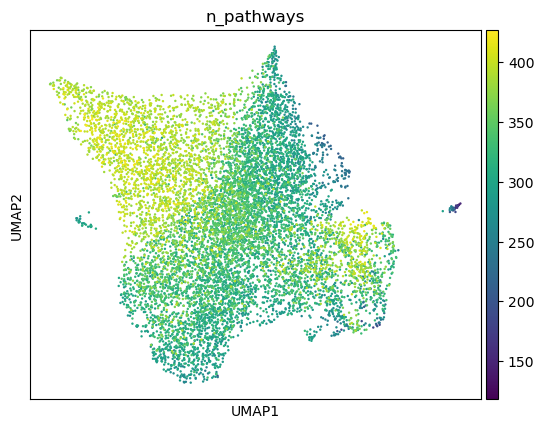

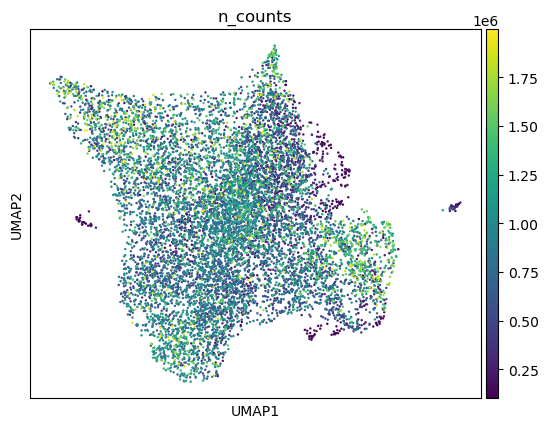

In [9]:
concat_ad = convertToAnnData(no_bc, metadata)

In [12]:
counts = concat_ad
dist = 'NB'
methodmap = {"P": "poisson", "ZIP": "zipoisson", 'NB': 'nb', 'ZINB': 'zinb'}

hid_size = 128
batch_size = 64

epochs = 200
K = 3
preds, loss = scAAnet(counts, dispersion='gene',
                                    hidden_size=(hid_size, K, hid_size), ae_type=methodmap[dist],
                                    epochs=epochs, batch_size=batch_size,
                                    early_stop=100, reduce_lr=10, learning_rate=0.01, 
                                    warm_up=20, random_state=5, return_loss=True)
recon, usage, spectra = preds['recon'], preds['usage'], preds['spectra']
usage = pd.DataFrame(usage, index=concat_ad.obs.index, columns = np.arange(1,K+1))
usage.columns = ['type1', 'type2', 'type3']
spectra = pd.DataFrame(np.transpose(spectra), index=concat_ad.var.index, columns=np.arange(1,K+1))
recon = pd.DataFrame(recon, index=concat_ad.obs.index, columns=concat_ad.var.index)

2025-01-25 14:11:48.497416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-25 14:11:51.093022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 62019 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0
2025-01-25 14:11:51.117101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 56933 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:3d:00.0, compute capability: 8.0
2025-01-25 14:11:51.120555: I tensorflow/core/comm

rmsprop at api
training starting, rmsprop
the optimizer is rmsprop


2025-01-25 14:11:54.289835: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


modified prints Training loss at epoch 0 (for the last batch): 6.6434
Learning rate is: 0.010000
<tf.Variable 'z_fixed/z_fixed:0' shape=(3, 2) dtype=float32, numpy=
array([[ 1.       ,  0.       ],
       [-0.5      ,  0.8660254],
       [-0.5      , -0.8660254]], dtype=float32)>
modified prints Training loss at epoch 1 (for the last batch): 6.4598
Learning rate is: 0.010000
<tf.Variable 'z_fixed/z_fixed:0' shape=(3, 2) dtype=float32, numpy=
array([[ 1.       ,  0.       ],
       [-0.5      ,  0.8660254],
       [-0.5      , -0.8660254]], dtype=float32)>
modified prints Training loss at epoch 2 (for the last batch): 6.1633
Learning rate is: 0.010000
<tf.Variable 'z_fixed/z_fixed:0' shape=(3, 2) dtype=float32, numpy=
array([[ 1.       ,  0.       ],
       [-0.5      ,  0.8660254],
       [-0.5      , -0.8660254]], dtype=float32)>
modified prints Training loss at epoch 3 (for the last batch): 6.0561
Learning rate is: 0.010000
<tf.Variable 'z_fixed/z_fixed:0' shape=(3, 2) dtype=float32,

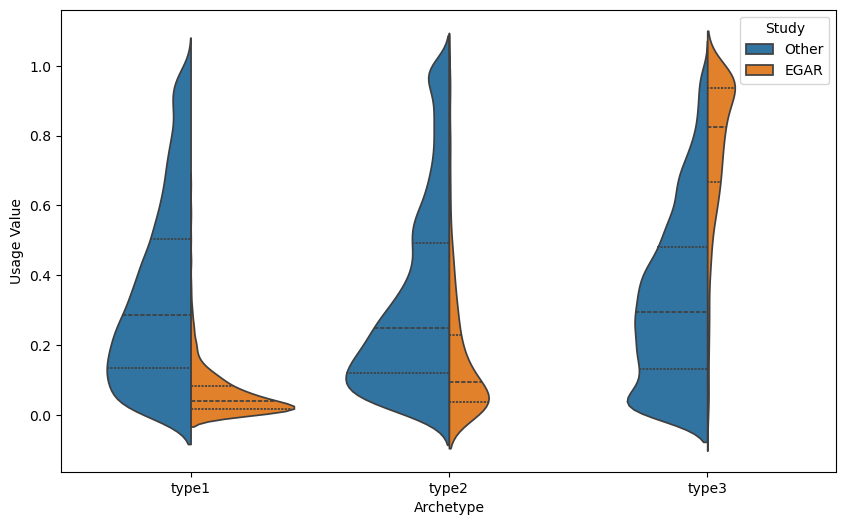

In [18]:
# Filter rows based on study column in metadata
egar_rows = metadata[metadata['study'] == 'EGAR']
other_rows = metadata[metadata['study'] != 'EGAR']  # Everything else is "Other"

# Add a new column to the usage dataframe to label the categories
usage['category'] = 'Other'  # Default category
usage.loc[egar_rows.index, 'category'] = 'EGAR'

# Filter usage to include only "EGAR" and "Other" categories
usage_filtered = usage[usage['category'].isin(['EGAR', 'Other'])]

# Melt the DataFrame for easier plotting
melted_usage = usage_filtered.melt(
    id_vars='category', 
    value_vars=['type1', 'type2', 'type3'], 
    var_name='Archetype',  # Label for the variable column
    value_name='Value'
)

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=melted_usage, x='Archetype', y='Value', hue='category', split=True, inner='quartile')
plt.xlabel('Archetype')
plt.ylabel('Usage Value')
plt.legend(title='Study')
plt.savefig(f"{figure_output}/S3A_pre_bc_usage_violin.pdf")
plt.show()
